In [2]:
import pickle
from typing import List

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp, odeint
from scipy.interpolate import interp1d

# helper functions for plotting
from utils import plot_lotka, plot_throw2

# set jupyter configurations
%matplotlib inline
%config InlineBackend.figure_format='retina'
default_dpi = mpl.rcParamsDefault["figure.dpi"]
mpl.rcParams["figure.dpi"] = default_dpi * 1.2

import jupyter_black

jupyter_black.load(lab=False)

## First simulator: Throwing a ball in air

A ballistic throw in air is modelled via a differential equation:

$\frac{d}{dt} x = v_x$

$a_x\frac{d}{dt} v_x = -\frac{k}{m} \cdot v_x \cdot s$

$\frac{d}{dt} z = v_z$

$a_z\frac{d}{dt} v_z = -\frac{k}{m} \cdot v_z \cdot s - g$

Here, $g$ is the gravitational acceleration, $k$ is the drag constant, $m$ is the mass of the object and $s=|v|= \sqrt{v_x^2 + v_z^2}$.


In [2]:
def throw(
    speed: float,
    angle: int,
    drag: float,
    r: float = 0.050,
    m: float = 0.2,
    h_noise: float = 3.0,
    ρ: float = 1.225,
    g: float = 9.81,
) -> dict:
    """Simulate the throw of a ball.
    
    Following https://scipython.com/book2/chapter-8-scipy/examples/a-projectile-with-air-resistance/
    
    Args:
        speed: magnitude of initial speed (m/s).
        angle: launch angle with horizontal (degrees)
        drag: drag coefficient
        r: projectile radius (m)
        m: projectile mass (kg)
        h_noise: std of measurements of altitude (m)
        ρ: air density (default is at sea surface, 15C)
        g: gravitational acceleration (default is average at surface of Earth)
    
    Returns:
        simulation: simulation results containing distance travelled
            and height as a function of time.
    """

    k = 0.5 * drag * ρ * (np.pi * r**2)  # drag constant, proportional to area

    def deriv(t, u):
        """Return right-hand side of ODE system for the throw."""
        # see diagram at e.g. http://www.physics.smu.edu/fattarus/ballistic.html

        #### INSERT YOUR CODE HERE ####
        x, v_x, z, v_z = u
        speed = ...
        a_x, a_z = ...

        ###############################

        return v_x, a_x, v_z, a_z

    # position and velocity components at launch
    x0, z0 = 0, 0
    rad_angle = np.radians(angle)
    v0_x, v0_z = speed * np.cos(rad_angle), speed * np.sin(rad_angle)

    # integration grid
    t = np.linspace(0, 400, 4000)

    # solve initial value problem (ivp) for distance traveled(t) and height(t)

    # df/dt = f(t,y); f(t_i) = y_i,

    #### INSERT YOUR CODE HERE ####

    solution = ...
    
    # use dense => continuous solution

    ###############################

    # evaluate solution to obtain distance and height at each time point
    d, _, h, _ = solution.sol(t)

    # the simulator always uses the same time grid, interpolate to the same distance grid
    f = interp1d(d, h, bounds_error=False)

    d_target = np.linspace(0, 150, 100)

    h_target = f(d_target)

    # add noise to make the process stochastic
    x = h_target + h_noise * np.random.randn(d_target.shape[0])

    # to obtain the params from the interactive plot, we need to return parameters here as well
    return dict(θ=(speed, angle, drag, r, m, h_noise, ρ, g), d=d_target, x=x)

If you run the cell below with throwing speed 40 m/s, angle 30 degrees and drag coefficient 0.13 and you implemented everything correctly, you should obtain circules that directly overlay the points I obtained when creating the simulation.

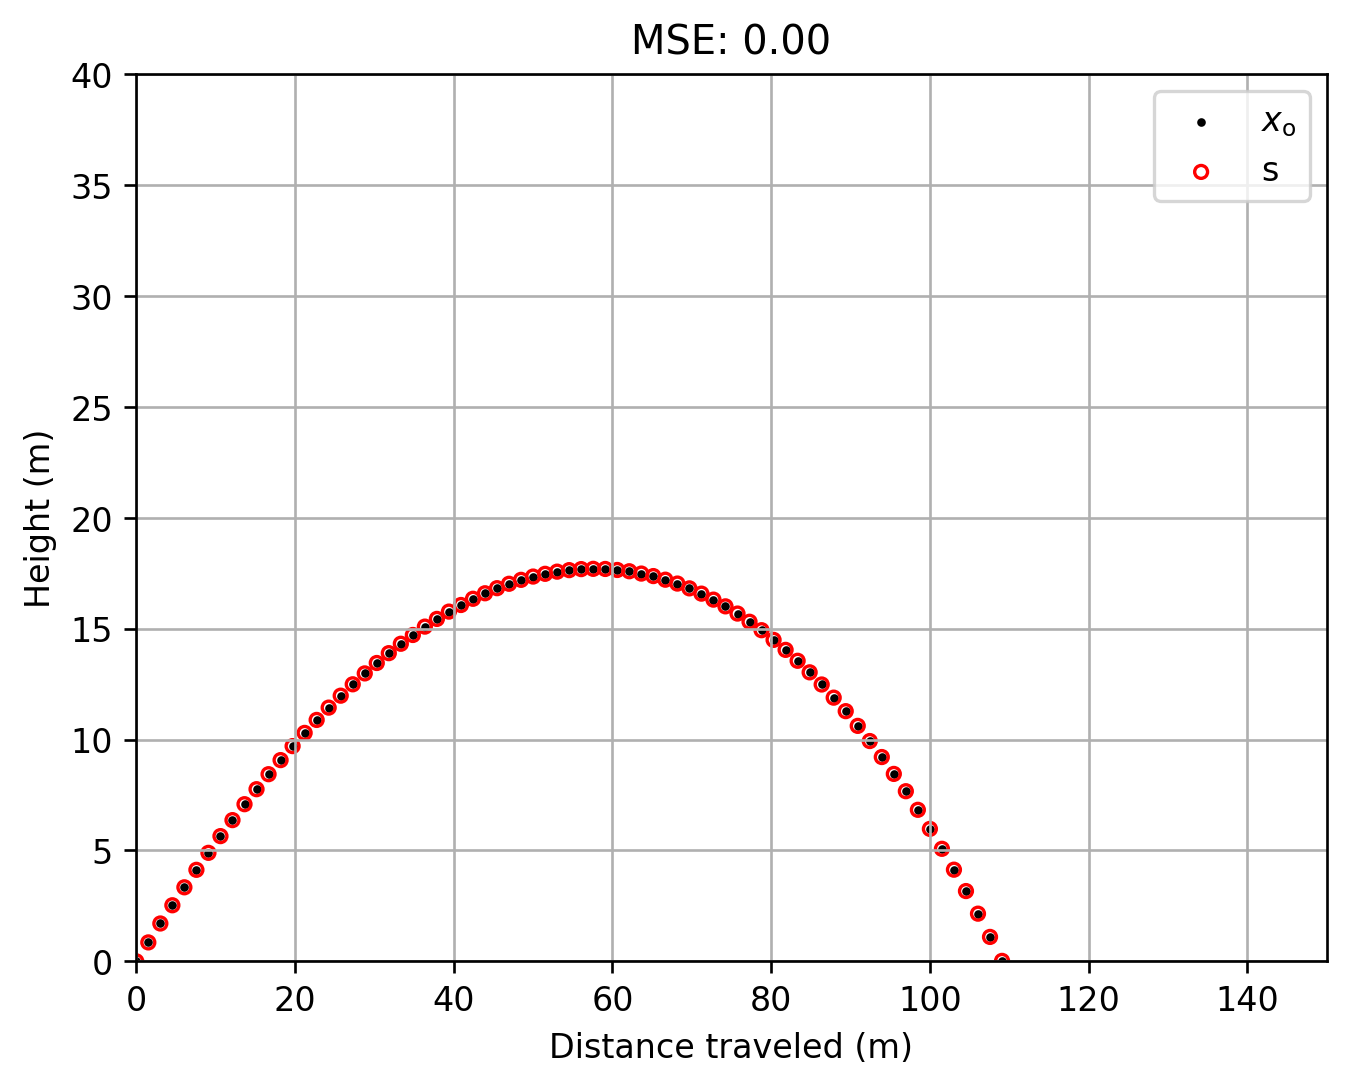

In [3]:
with open("throw-x_o-1.pickle", "rb") as f:
    d_o, x_o = pickle.load(f)

sim = throw(40, 30, 0.13, h_noise=0)  # run the simulation without noise

d, x = sim["d"], sim["x"]

plot_throw2(d_o, x_o, d, x)

Run the simulator with different parameter settings for speed, angle and drag. What changes if you keep all parameters the same but change one of them?

## Second simulator: Lotka-Volterra Model

The Lotka-Volterra (aka Prey-Predator) model is a model that describes the evolution of the population of two species (e.g. foxes and rabbits):

$\frac{du}{dt} = au - buv + \epsilon$  
$\frac{dv}{dt} = -cv + dbuv + \epsilon$

```
| a   | prey reproduction rate |
| b   | prey death rate per predator |
| c   | predator death rate (if no prey) |
| d   | predators born per prey |
```
```
| u   | prey / rabbits
| v   | predator / foxes
```
$\epsilon$ is Gaussian noise.

First, let's define the simulator. 

In [69]:
def lotka_volterra(θ: List, X0: np.array, t: np.array) -> np.array:
    """Simulate Lotka-Volterra model for prey-predator dynamics.
    
    Following: https://scipy-cookbook.readthedocs.io/items/LoktaVolterraTutorial.html
    
    Args:
        θ: parameter array [a, b, c, d]
        X0: initial value array [u, v]
        t: time array
    
    Returns:
        simulation: array containing simulation results
    """

    a, b, c, d = θ

    def dX_dt(X, t):
        # Args:
        #   X: current number of rabbits u and foxes v
        #   t: current time
        # Returns:
        #   Array of size (2,) containing temporal derivative of u and v
        X.shape
        u, v = X

        #### INSERT YOUR CODE HERE ####

        return ...

        #### ##################### ####

    X = odeint(dX_dt, X0, t)

    # add noise to make the process stochastic
    X = np.round(X + .3 * X * np.random.randn(X.shape[0],X.shape[1]))

    
    return X

Run the simulator and plot the results. Think about the following questions:
* Describe the dynamics of rabbits and foxes in your own words
* What happens if you change the starting conditions u or v? 
* What happens if you slightly change the parameters a, b, c, d?

<AxesSubplot:xlabel='Time', ylabel='Population'>

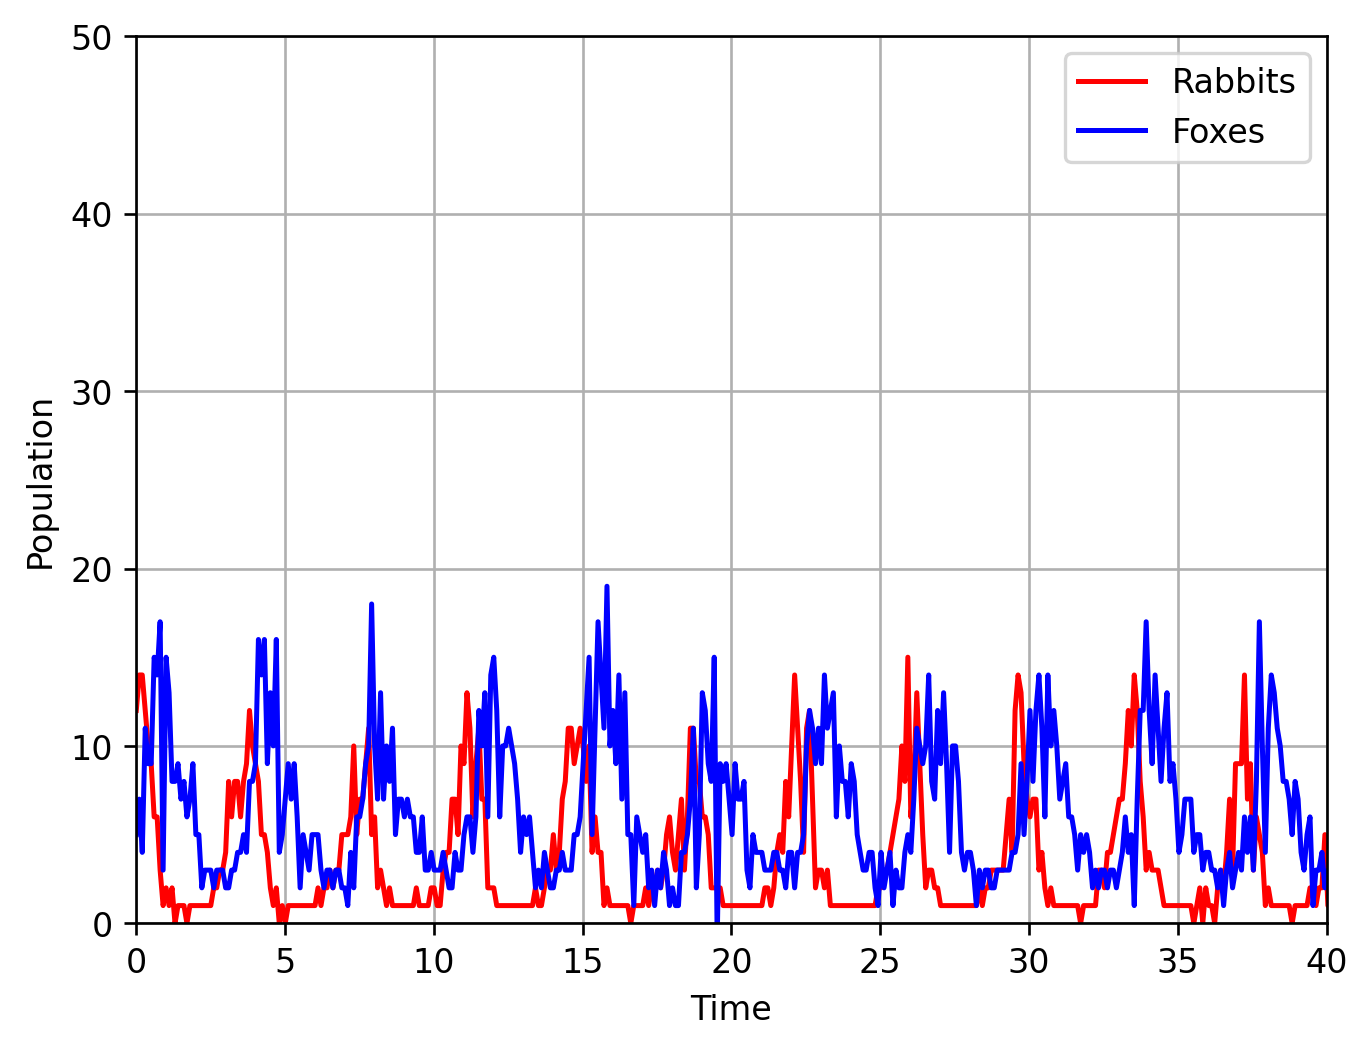

In [88]:
# time
t = np.linspace(0, 100, 1000)

# initials conditions: 10 rabbits and 5 foxes
X0 = np.array([10, 5])

# parameters (a, b, c, d)
θ = [3.1, .5, 1.1, .3]

# run the simulation
X = lotka_volterra(θ, X0, t)

rabbits, foxes = X.T

plot_lotka(t, rabbits, foxes)